In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from Environment import Environment
from Agent import Agent
import numpy as np
from plot import plot
from Display import disp
from termcolor import colored
from tqdm import tqdm
from math import log, exp

2023-08-27 17:20:19.787607: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-27 17:20:19.994502: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-08-27 17:20:19.994528: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-08-27 17:20:20.054612: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-08-27 17:20:21.067719: W tensorflow/stream_executor/platform/de

In [38]:
def run(episodes: int, iterations: int, env=None, agent=None, method="Episods_Iterations"):
    sigma = 1e-2
    if env == None:
        env = Environment(num_of_antennas=10, num_of_irs1=10, num_of_irs2=10,
                            path_loss_exponent=2, irs1_to_antenna=20,
                            irs2_to_antenna=30, irs1_to_irs2=40, transmitted_power=1)

        U1 = env.CreateUser(distance_to_antenna=50, distance_to_irs1=50, distance_to_irs2=30,
                            noise_var=sigma**2, los_to_antenna=False, los_to_irs1=False,
                            los_to_irs2=True, sinr_threshold=3, penalty=0, allocated_power=0.5, weight=1)

        U2 = env.CreateUser(distance_to_antenna=60, distance_to_irs1=40, distance_to_irs2=20,
                            noise_var=sigma**2, los_to_antenna=True, los_to_irs1=True,
                            los_to_irs2=True, sinr_threshold=3, penalty=0, allocated_power=0.5, weight=1)
    

    num_of_actions = env.M1 + env.M2 + len(env.Users) * env.N + env.num_of_users - 1

    if agent == None:
        agent = Agent(input_dims=env.num_of_users, bound=1, batch_size=128,
                         n_actions=num_of_actions)


    num_of_episodes = episodes
    num_of_iterations = iterations

    score_history = np.zeros((num_of_episodes,))
    rewards = np.zeros((num_of_episodes, num_of_iterations))
    sumrate = np.zeros((num_of_episodes, num_of_iterations))
    U1_SINR = np.zeros((num_of_episodes, num_of_iterations))
    U2_SINR = np.zeros((num_of_episodes, num_of_iterations))

    Old_Avg = 0
    learn_iters = 0
    n_steps = 0
    N = 100 # 

    for ep in range(num_of_episodes):
        score = 0
        obs = env.State()

        for iter in range(num_of_iterations):
            action, probs, vals = agent.choose_action(obs)
            # print(action.shape)
            new_state, reward, sumrate[ep][iter], SINRs = env.Step(action)
            
            obs = new_state
            score += reward
            n_steps += 1
            agent.remember(obs, action, probs, vals, reward, False)
            
            if n_steps % N == 0:
                agent.learn()
                learn_iters += 1

            
            rewards[ep][iter] = reward

            U1_SINR[ep][iter] = SINRs[0]
            U2_SINR[ep][iter] = SINRs[1]

        score = score / num_of_iterations
        score_history[ep] = score
        New_Avg = score_history[:ep + 1].mean()

        disp(episod=ep, score=score, score_history=score_history,
                New_Avg=New_Avg, Old_Avg=Old_Avg, SINRs=SINRs, sumrate=sumrate[ep][iter])
        
        ac = np.array(action)
        power_noise = np.array(agent.power_noise)
        print("Power split factor = "+ colored(f"{ac[-1 : ][0]: <5.2}", "blue") +
            "| Power noise = " + colored(f"{power_noise[-1]: <5.2}", "blue") )
        
        # print(agent.memory.buffer_counter)

        # obs = env.Reset()
        Old_Avg = New_Avg

    plot(score_history=score_history, sumrate=sumrate,
            u1_sinr=U1_SINR, u2_sinr=U2_SINR, mean=False,
            title=f"N = {env.N}, M1 = {env.M1}, M2 = {env.M2}", method=method)
    
    return agent
    

In [39]:
def run2(iterations: int, env=None, agent=None, method="Iterations_Only"):
    sigma = 1e-2

    if env == None : 
        env = Environment(num_of_antennas=10, num_of_irs1=10, num_of_irs2=10,
                            path_loss_exponent=2, irs1_to_antenna=20,
                            irs2_to_antenna=30, irs1_to_irs2=40, transmitted_power=1)

        U1 = env.CreateUser(distance_to_antenna=50, distance_to_irs1=50, distance_to_irs2=30,
                            noise_var=sigma**2, los_to_antenna=False, los_to_irs1=False,
                            los_to_irs2=True, sinr_threshold=3, penalty=0, allocated_power=0.5, weight=1)

        U2 = env.CreateUser(distance_to_antenna=60, distance_to_irs1=40, distance_to_irs2=20,
                            noise_var=sigma**2, los_to_antenna=True, los_to_irs1=True,
                            los_to_irs2=True, sinr_threshold=3, penalty=0, allocated_power=0.5, weight=1)
        

    num_of_actions = env.M1 + env.M2 + len(env.Users) * env.N + env.num_of_users - 1

    if agent == None :
        agent = Agent(num_states=env.num_of_users, bound=1, batch_size=128, max_size=100000,
                        env=env, n_actions=num_of_actions,
                        noise=0.02, alpha=0.0002, beta=0.0004, fc1=512, fc2=256)


    num_of_iterations = iterations
    rewards = np.zeros((1, num_of_iterations))
    sumrate = np.zeros((1, num_of_iterations))
    U1_SINR = np.zeros((1, num_of_iterations))
    U2_SINR = np.zeros((1, num_of_iterations))

    obs = env.State()

    for iter in tqdm(range(num_of_iterations), desc= colored("Agent is Learning :) ", "green"), ncols=123, colour= "red"):

        # if iter < num_of_iterations / 5:
        #     agent.noise = 0.5
        # elif iter < num_of_iterations * 2 / 5:
        #     agent.noise = 0.4
        # elif iter < num_of_iterations * 3 / 5:
        #     agent.noise = 0.3
        # elif iter < num_of_iterations * 4 / 5:
        #     agent.noise = 0.2
        # elif iter < num_of_iterations - 300 :
        #     agent.noise = 0.1
        # else:
        #     agent.noise = 0.001

        # agent.noise = (0.5) / (log(iter + 1, 10) + 1)

        if iter < num_of_iterations / 2:
            agent.noise = (0.5) * exp(-(iter / 4000) ** 1.1)

        else:
            agent.noise = (0.5) * exp(-(iter / 2000) ** 1.1)
    

        action = agent.choose_action(obs)

        new_state, reward, sumrate[0][iter], SINRs = env.Step(action)
        # if reward != 0 : 
        agent.remember(obs, action, reward, new_state)
            
        agent.learn()
        obs = new_state
        rewards[0][iter] = reward
        U1_SINR[0][iter] = SINRs[0]
        U2_SINR[0][iter] = SINRs[1]

    plot(score_history=np.array([1]), sumrate=sumrate,
            u1_sinr=U1_SINR, u2_sinr=U2_SINR, mean=False,
            title=f"N = {env.N}, M1 = {env.M1}, M2 = {env.M2}", method=method)

    return agent


In [40]:
# Construct 2 equivalent environment
sigma = 1e-2
env1 = Environment(num_of_antennas=5, num_of_irs1=5, num_of_irs2=5,
                            path_loss_exponent=2, irs1_to_antenna=20,
                            irs2_to_antenna=30, irs1_to_irs2=40, transmitted_power=1)

U11 = env1.CreateUser(distance_to_antenna=50, distance_to_irs1=50, distance_to_irs2=30,
                            noise_var=sigma**2, los_to_antenna=True, los_to_irs1=True,
                            los_to_irs2=True, sinr_threshold=3, penalty=0, allocated_power=0.5, weight=1)

U21 = env1.CreateUser(distance_to_antenna=60, distance_to_irs1=40, distance_to_irs2=20,
                    noise_var=sigma**2, los_to_antenna=True, los_to_irs1=True,
                    los_to_irs2=True, sinr_threshold=3, penalty=0, allocated_power=0.5, weight=1)
#-------------------------------------------------------------------------------------------------------

env2 = Environment(num_of_antennas=5, num_of_irs1=5, num_of_irs2=5,
                            path_loss_exponent=2, irs1_to_antenna=20,
                            irs2_to_antenna=30, irs1_to_irs2=40, transmitted_power=1)

U12 = env2.CreateUser(distance_to_antenna=50, distance_to_irs1=50, distance_to_irs2=30,
                            noise_var=sigma**2, los_to_antenna=True, los_to_irs1=True,
                            los_to_irs2=True, sinr_threshold=3, penalty=0, allocated_power=0.5, weight=1)

U22 = env2.CreateUser(distance_to_antenna=60, distance_to_irs1=40, distance_to_irs2=20,
                    noise_var=sigma**2, los_to_antenna=True, los_to_irs1=True,
                    los_to_irs2=True, sinr_threshold=3, penalty=0, allocated_power=0.5, weight=1)

env2.Hs1 = env1.Hs1
env2.Hs2 = env1.Hs2
env2.H12 = env1.H12
env2.H21 = env1.H21
env2.Psi1 = env1.Psi1
env2.Psi2 = env1.Psi2

U12.h1u = U11.h1u
U12.hsu = U11.hsu
U12.h2u = U11.h2u
U12.w = U11.w

U22.h1u = U21.h1u
U22.hsu = U21.hsu
U22.h2u = U21.h2u
U22.w = U21.w

In [41]:
agent = run(40, 100, env=env1)

InvalidArgumentError: {{function_node __wrapped__Mul_device_/job:localhost/replica:0/task:0/device:CPU:0}} Incompatible shapes: [100] vs. [100,21] [Op:Mul]

Agent is Learning :) : 100%|███████████████████████████████████████████████████████████| 6000/6000 [03:29<00:00, 28.57it/s]


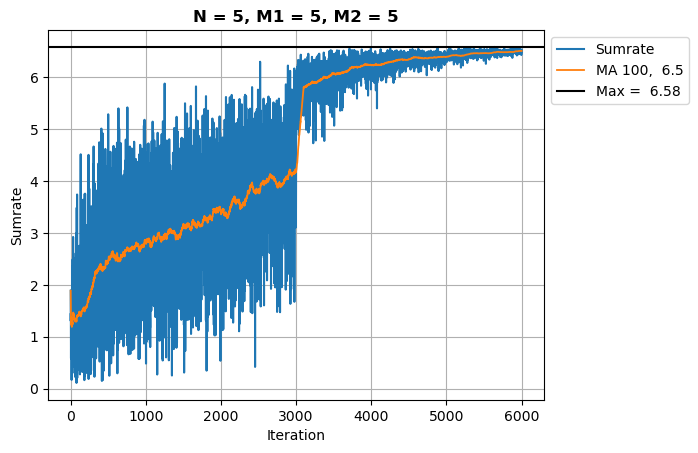

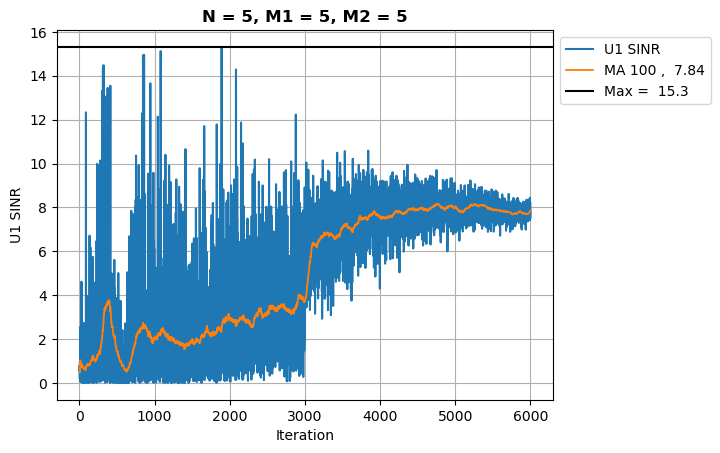

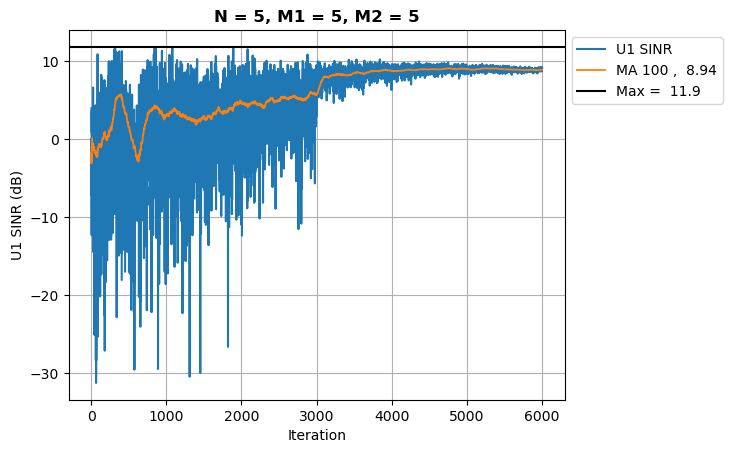

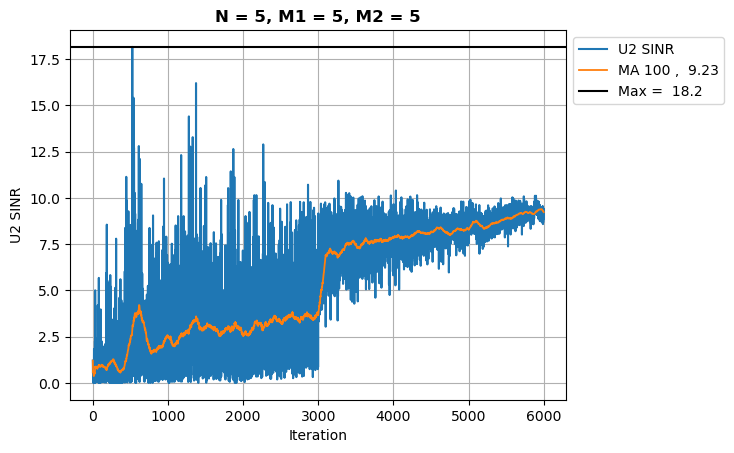

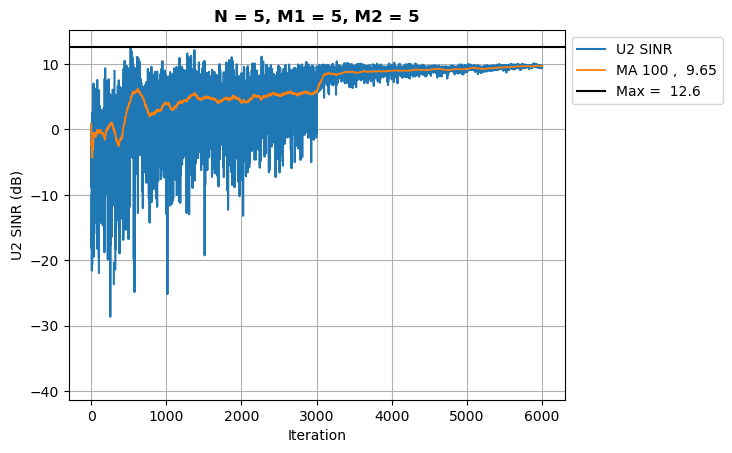

In [21]:
agent1 = run2(6000, env=env2)

Agent is Learning :) : 100%|███████████████████████████████████████████████████████████| 4000/4000 [02:24<00:00, 27.63it/s]


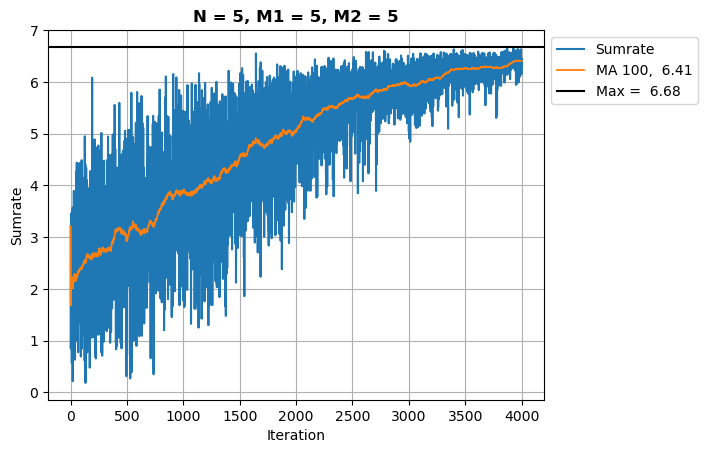

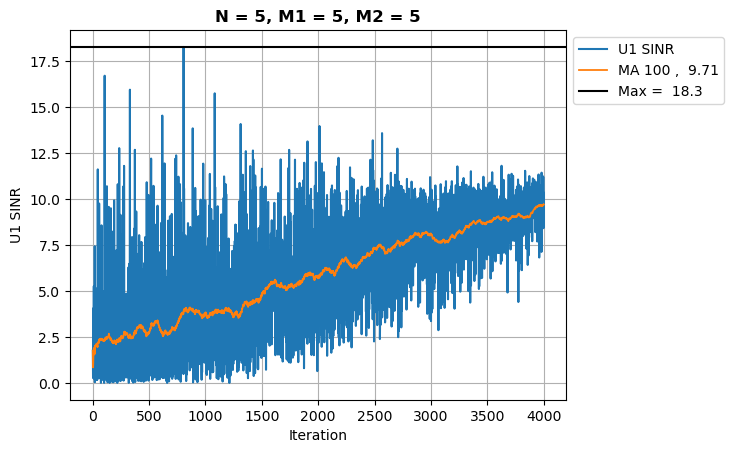

/mnt/c/Users/danes/Desktop/IRS-Project/src/plot.py:88: RuntimeWarning: divide by zero encountered in log10
  np.log10(u1_sinr), linewidth=1.5, label='U1 SINR')


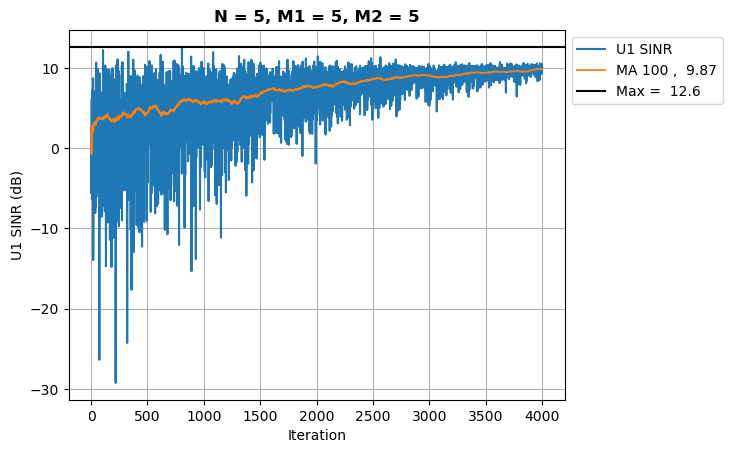

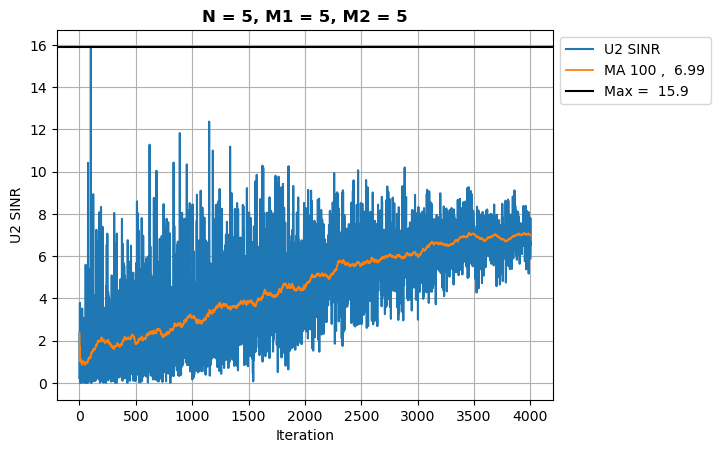

/mnt/c/Users/danes/Desktop/IRS-Project/src/plot.py:144: RuntimeWarning: divide by zero encountered in log10
  np.log10(u2_sinr), linewidth=1.5, label='U2 SINR')


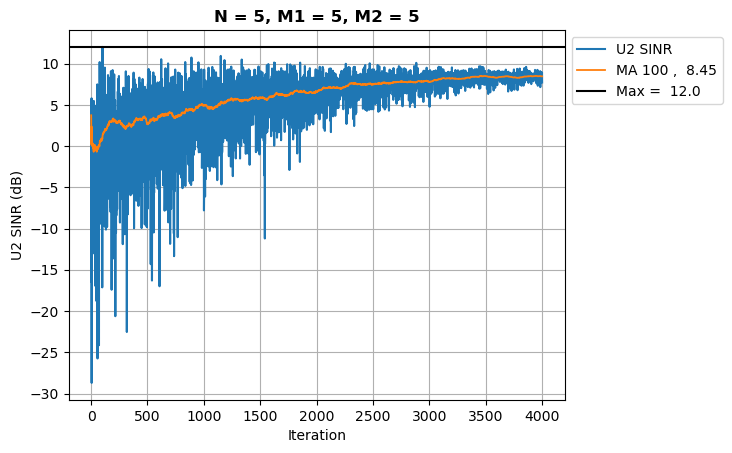

In [14]:
agent2 = run2(4000, env=env1, agent=agent1)

In [ ]:
print(np.diag(np.angle(env.Psi1, deg=True)))
print("************************************************************************************")
print(np.diag(np.angle(env.Psi2, deg=True)))
print("************************************************************************************")
print(max(sumrate.reshape(num_of_episodes*num_of_iterations,)))

[  5.80351911 102.90995479 123.30667377  60.71778774  78.84238601]
************************************************************************************
[1.80000000e+02 1.80000000e+02 1.79999979e+02 1.78838679e+02
 6.44566103e-04]
************************************************************************************
6.4951752893006685


In [18]:
print(np.linalg.norm(U11.w)**2 + np.linalg.norm(U21.w)**2)
print(U11.allocated_power , U21.allocated_power)

1.0
0.514385998249054 0.48561400175094604


In [48]:
print(env1.SINR, env1.SumRate)
print(env2.SINR, env2.SumRate)

[20.180652990053186, 13.479671442466971] 8.260632124101356
[18.405552395336056, 9.85741100653092] 7.719005818705186


In [4]:
sigma = 1e-2

env = Environment(num_of_antennas=4, num_of_irs1=5, num_of_irs2=5,
    path_loss_exponent=2, irs1_to_antenna=20,
    irs2_to_antenna=30, irs1_to_irs2=40, transmitted_power=1)

U1 = env.CreateUser(distance_to_antenna=50, distance_to_irs1=50, distance_to_irs2=30,
    noise_var=sigma**2, los_to_antenna=False, los_to_irs1=False,
    los_to_irs2=True, sinr_threshold=3, penalty=0, allocated_power=0.5, weight=1)

U2 = env.CreateUser(distance_to_antenna=60, distance_to_irs1=40, distance_to_irs2=20,
    noise_var=sigma**2, los_to_antenna=True, los_to_irs1=True,
    los_to_irs2=True, sinr_threshold=3, penalty=0, allocated_power=0.5, weight=1)


num_of_actions = env.M1 + env.M2 + len(env.Users) * env.N + env.num_of_users - 1

agent = Agent( batch_size=128,n_actions=num_of_actions)

num_of_episodes = 20
num_of_iterations = 100

score_history = np.zeros((num_of_episodes,))
rewards = np.zeros((num_of_episodes, num_of_iterations))
sumrate = np.zeros((num_of_episodes, num_of_iterations))
U1_SINR = np.zeros((num_of_episodes, num_of_iterations))
U2_SINR = np.zeros((num_of_episodes, num_of_iterations))

Old_Avg = 0
learn_iters = 0
n_steps = 0
N = 100 # 

for ep in range(num_of_episodes):
    score = 0
    obs = env.State()

    for iter in range(num_of_iterations):
        action, probs, vals = agent.choose_action(obs)
        # print(action.shape)
        new_state, reward, sumrate[ep][iter], SINRs = env.Step(action)
        
        obs = new_state
        score += reward
        n_steps += 1
        agent.remember(obs, action, probs, vals, reward, False)
        
        if n_steps % N == 0:
            agent.learn()
            learn_iters += 1

        
        rewards[ep][iter] = reward

        U1_SINR[ep][iter] = SINRs[0]
        U2_SINR[ep][iter] = SINRs[1]

    score = score / num_of_iterations
    score_history[ep] = score
    New_Avg = score_history[:ep + 1].mean()

    disp(episod=ep, score=score, score_history=score_history,
            New_Avg=New_Avg, Old_Avg=Old_Avg, SINRs=SINRs, sumrate=sumrate[ep][iter])
    
    ac = np.array(action)
    power_noise = np.array(agent.power_noise)
    print("Power split factor = "+ colored(f"{ac[-1 : ][0]: <5.2}", "blue") +
        "| Power noise = " + colored(f"{power_noise[-1]: <5.2}", "blue") )
    
    # print(agent.memory.buffer_counter)

    # obs = env.Reset()
    Old_Avg = New_Avg

# plot(score_history=score_history, sumrate=sumrate,
#         u1_sinr=U1_SINR, u2_sinr=U2_SINR, mean=False,
#         title=f"N = {env.N}, M1 = {env.M1}, M2 = {env.M2}", method=method)




ValueError: No gradients provided for any variable: (['actor_network_1/dense_6/kernel:0', 'actor_network_1/dense_6/bias:0', 'actor_network_1/dense_7/kernel:0', 'actor_network_1/dense_7/bias:0', 'actor_network_1/dense_8/kernel:0', 'actor_network_1/dense_8/bias:0'],). Provided `grads_and_vars` is ((None, <tf.Variable 'actor_network_1/dense_6/kernel:0' shape=(2, 256) dtype=float32, numpy=
array([[-0.11545792,  0.08489391, -0.01236716,  0.08606942, -0.06677401,
        -0.07201621, -0.04911694,  0.1111697 , -0.01512535, -0.049963  ,
         0.00163838, -0.01425591,  0.04881452, -0.0707128 ,  0.1068005 ,
         0.07064012,  0.03537518, -0.10007963,  0.01941893,  0.04949984,
         0.01435415,  0.01358281,  0.08186994, -0.01290283,  0.0779065 ,
         0.14308283,  0.02023859,  0.03583734,  0.06179683, -0.02960272,
         0.01029868, -0.02237411,  0.07447706, -0.08453085, -0.0727396 ,
        -0.13480431, -0.01728864, -0.11398682,  0.11790574, -0.10368024,
         0.03767413, -0.05149475, -0.10210384,  0.10190457, -0.00413822,
         0.11411387,  0.143329  ,  0.00737751,  0.00722152, -0.01633365,
         0.1492495 ,  0.12897193,  0.0036197 , -0.1016882 ,  0.04289499,
         0.12171471,  0.00523603,  0.1121693 ,  0.04435147,  0.0304613 ,
         0.02731279, -0.1105797 ,  0.03539085,  0.14258951,  0.13694808,
         0.0027775 ,  0.11453688,  0.08484338,  0.08948298,  0.02613351,
        -0.14708628, -0.07630833, -0.09008424,  0.13742211,  0.13822582,
         0.09933782,  0.08429506,  0.14175192, -0.09066351,  0.13025564,
         0.12413374,  0.05410492, -0.05417012, -0.01336226, -0.14802007,
         0.0077685 ,  0.03723325,  0.06283166,  0.13122582, -0.11807482,
        -0.05808149,  0.13347876,  0.14143527,  0.14586332, -0.01549798,
         0.09384069,  0.08739898,  0.03774332,  0.02136712, -0.12770608,
        -0.13816032,  0.00816743,  0.14405948, -0.12607414, -0.04709949,
        -0.03673117,  0.02133495,  0.06045541, -0.14462413, -0.00077876,
         0.01471595, -0.11426453, -0.06645125,  0.11393932, -0.13266435,
         0.02511427,  0.03062189,  0.09302546, -0.06606062,  0.08821556,
         0.05962811, -0.02051212, -0.09832718, -0.08489247,  0.05428709,
        -0.10004439, -0.0599985 ,  0.11080617, -0.01820771,  0.01547632,
         0.03277089, -0.1352944 , -0.1401152 ,  0.09191085, -0.03863948,
         0.04626848,  0.00618902,  0.050797  ,  0.11606875, -0.02574684,
        -0.10817921, -0.00786914, -0.14192007,  0.0749539 ,  0.00983727,
        -0.07536592,  0.13186455,  0.12336802,  0.0619299 , -0.03998373,
        -0.02343032,  0.08681735, -0.07924581, -0.10286286,  0.14025497,
        -0.10727809, -0.06340899,  0.13374186,  0.02584431,  0.10968658,
        -0.07677311,  0.14472005, -0.11787711, -0.05457854, -0.12668768,
         0.00735332, -0.0669281 , -0.0564073 ,  0.12913871, -0.07839952,
         0.10415363,  0.13744599, -0.02984211,  0.14127183,  0.10068509,
        -0.14465757,  0.0480379 , -0.10398929,  0.12217838,  0.13448173,
        -0.04025449,  0.12560925, -0.14624996,  0.04041515,  0.02193896,
         0.0547941 , -0.02610344, -0.13589212, -0.13125508, -0.02593619,
         0.02712119,  0.02289709,  0.06246008,  0.11857644,  0.12579104,
        -0.14619772, -0.01573832, -0.08594406,  0.08758423,  0.11267504,
         0.11854932,  0.01792651, -0.07063459,  0.12610394,  0.0653352 ,
        -0.1261059 , -0.14154343,  0.03364764,  0.08706066, -0.03700058,
        -0.04988272, -0.01910487, -0.13002197, -0.04170959, -0.01088279,
         0.13853359,  0.10698083,  0.10832125, -0.01459786, -0.10730766,
        -0.10017419,  0.12293297, -0.03364979,  0.05055375, -0.01472566,
        -0.13345473, -0.13644758, -0.04277613,  0.02891587,  0.08101839,
         0.11797142,  0.00763136, -0.11617437, -0.08123025, -0.10587302,
         0.14091587, -0.08388042, -0.06685178, -0.11651628, -0.01181771,
         0.10015687,  0.14334932,  0.00904086, -0.11503674, -0.06533341,
        -0.00150986,  0.13211787,  0.02405387,  0.02276136, -0.1363894 ,
        -0.11615106, -0.05055565,  0.02714522,  0.01779446, -0.01809824,
        -0.06313663],
       [ 0.14560792,  0.07755958, -0.07912131,  0.03972147, -0.11100888,
         0.09083894,  0.00931399,  0.00865768, -0.13035724, -0.05179238,
        -0.10404135, -0.14634144, -0.04948049,  0.05078976,  0.14946002,
         0.02657235,  0.1519    ,  0.13949114, -0.12888795, -0.04574702,
         0.12041983, -0.00952734,  0.01071361, -0.12214592, -0.01013282,
         0.09372497,  0.03435987,  0.12467068, -0.06047563,  0.06280552,
        -0.05433235, -0.0909512 , -0.00285876,  0.10064438,  0.12033433,
        -0.07933772, -0.11877247, -0.07315867,  0.14511168,  0.01158935,
        -0.07094447, -0.11838932,  0.06642461, -0.02015519, -0.02843696,
        -0.05815199,  0.09734623,  0.13280666,  0.14345178, -0.12767059,
         0.09436738, -0.09543588, -0.06895639,  0.05380282, -0.02454682,
        -0.09108966,  0.04476272, -0.03032949,  0.00017533, -0.04234488,
         0.03189236,  0.10915694, -0.14116126,  0.02303688,  0.03852797,
         0.06526834, -0.00799294, -0.00573123,  0.03266589,  0.09283076,
        -0.14445956, -0.03198195, -0.05622736, -0.05288249,  0.09332047,
         0.09046187, -0.14604615,  0.006565  , -0.11075335, -0.1100885 ,
         0.07060924,  0.12357044,  0.02585249, -0.05040218,  0.10836986,
         0.00306661, -0.0805245 ,  0.11849025, -0.10291861,  0.07300338,
         0.11590785, -0.14831796, -0.12517837, -0.14153874,  0.00038677,
         0.14319575,  0.12903938, -0.00285393, -0.07579306,  0.01155378,
        -0.03702673,  0.11043641, -0.12211316, -0.07777718,  0.10137972,
         0.09469886, -0.08937441,  0.01578766,  0.08756706,  0.01554511,
        -0.0122045 , -0.00915128,  0.04716274, -0.12777175,  0.0536043 ,
        -0.07673573,  0.03444441,  0.10651407,  0.14533147, -0.03825451,
         0.11487511, -0.10498435,  0.03291273,  0.05869046,  0.14088497,
         0.11671865,  0.08223124,  0.00471365, -0.10538168, -0.03785119,
        -0.1432717 ,  0.13135743, -0.02109379,  0.12620375, -0.02876499,
         0.03887184, -0.0533499 , -0.05197999, -0.10090601, -0.10369191,
         0.05603531,  0.0518041 ,  0.00193579, -0.02358052,  0.07548332,
         0.12715611, -0.07979108, -0.0153967 ,  0.04375879,  0.12794706,
        -0.08133908, -0.02881502,  0.11188141,  0.05888069,  0.12637898,
        -0.08439508,  0.00375435,  0.00270173, -0.01898448, -0.11407575,
         0.04937999, -0.08660422,  0.12115383, -0.0262789 ,  0.04923809,
         0.09498703,  0.12022778, -0.12803909,  0.0998033 , -0.03218483,
        -0.08310769, -0.10637208,  0.0172729 ,  0.0722736 ,  0.04352032,
         0.0794276 ,  0.08004697,  0.14577317,  0.06415489,  0.02091748,
        -0.08790102, -0.03669765,  0.08054796,  0.10041398,  0.12076423,
         0.11916816, -0.00388767,  0.11638477,  0.04795064, -0.14546731,
         0.03591307, -0.1450484 ,  0.02334702,  0.14272436, -0.02306662,
        -0.08222528, -0.0126906 , -0.10036537,  0.08841145, -0.09574838,
         0.11312634,  0.04095097, -0.09665316, -0.06175352, -0.10248438,
        -0.01371886, -0.01115158, -0.05761934, -0.04424443, -0.07505196,
         0.04016985,  0.08555514, -0.02352151, -0.06549954, -0.14160691,
        -0.03210887, -0.05818235, -0.14538646,  0.0276911 ,  0.09662183,
        -0.11405358,  0.05816767,  0.11510688, -0.06554938, -0.13648738,
        -0.06017749,  0.02520698,  0.0962666 , -0.00556271,  0.0216468 ,
        -0.00705311, -0.13694234,  0.03288971,  0.11119473, -0.13090202,
        -0.0493296 ,  0.1218527 , -0.02983443, -0.01698746,  0.0701627 ,
        -0.13132747,  0.0841438 , -0.06676023, -0.07513948, -0.05800576,
         0.01907596,  0.06943454,  0.0761316 ,  0.02865933,  0.08364442,
        -0.11516087,  0.07197003, -0.09985722, -0.08345518, -0.00465763,
         0.13731578]], dtype=float32)>), (None, <tf.Variable 'actor_network_1/dense_6/bias:0' shape=(256,) dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0.], dtype=float32)>), (None, <tf.Variable 'actor_network_1/dense_7/kernel:0' shape=(256, 256) dtype=float32, numpy=
array([[-0.04988551,  0.09162662,  0.09590838, ..., -0.05954239,
        -0.00250103, -0.0881484 ],
       [ 0.03369922, -0.02765797,  0.0633432 , ..., -0.04112303,
        -0.02039026, -0.08671455],
       [ 0.01528719,  0.09171144, -0.09616859, ...,  0.03475463,
         0.01727308, -0.06312636],
       ...,
       [ 0.01152389,  0.062937  ,  0.0664371 , ...,  0.08757762,
         0.01966744,  0.0639965 ],
       [ 0.01029293, -0.08278927,  0.00604311, ...,  0.09233397,
         0.08443361, -0.08678054],
       [ 0.03738797, -0.07616711, -0.04933205, ...,  0.0019417 ,
         0.05078151, -0.05088808]], dtype=float32)>), (None, <tf.Variable 'actor_network_1/dense_7/bias:0' shape=(256,) dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0.], dtype=float32)>), (None, <tf.Variable 'actor_network_1/dense_8/kernel:0' shape=(256, 19) dtype=float32, numpy=
array([[ 1.07058227e-01, -9.82283354e-02,  1.87655985e-02, ...,
         1.46192163e-02,  8.42721462e-02, -8.24821517e-02],
       [ 2.60560662e-02,  1.09291375e-02, -1.22552514e-02, ...,
        -8.08214396e-02, -2.58370936e-02, -4.44587246e-02],
       [-1.37429625e-01,  1.41928852e-01,  2.85196900e-02, ...,
        -1.46579325e-01,  1.37528092e-01, -1.39013156e-01],
       ...,
       [-1.19225696e-01,  1.10986233e-01, -3.07112932e-05, ...,
        -7.46956617e-02, -1.36462152e-02, -1.56407058e-02],
       [-3.16171795e-02,  1.21546656e-01, -3.25319394e-02, ...,
         2.65040994e-02,  6.65670633e-03, -1.01049662e-01],
       [-2.94308886e-02,  1.90632045e-03,  4.40789908e-02, ...,
        -7.01748505e-02, -4.96666133e-02,  1.11196488e-02]], dtype=float32)>), (None, <tf.Variable 'actor_network_1/dense_8/bias:0' shape=(19,) dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0.], dtype=float32)>)).